In [1]:
# Author: Volker Hoffmann, SINTEF <volker.hoffmann@sintef.no> <volker@cheleb.net>
# Update: 09 January 2018

In this notebook, we'll cover some of the basics of doing time series analysis in Python by way of an example analysis of a publically available energy consumption dataset. We'll introduce `Pandas` to manage our time series data, `Matplotlib` to make some figures, `Numpy` for general vector/array processing, and `Sklearn` (Scikit-Learn) for machine learning..

A Jupyter notebook is divided into cells of execution (much like Mathematica). Each cell can be executed individually and in any order. While this is great for rapid experimentation, the space of global variables may become a bit messy if we're not careful.

The first three cells set up our environment.

In [2]:
%matplotlib inline

In [3]:
import matplotlib as mpl; mpl.rcParams['figure.dpi'] = 72
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import datetime
import sklearn.tree

In [4]:
plt.style.use('ggplot')

# Load UkDale

We will be using Pandas to manage our time series data in memory. Pandas is structured around the concept of data frame, which you can consider as a sort of in-memory database table. Pandas also comes with many convenience functions to help with common manipulations of the data frame.

Pandas can load data from a variety of sources, the most common being connections into SQL databases or from flat files. Here, we will load some time-series data from the UkDale energy consumption dataset into memory.

For more information on the UkDale dataset, see http://jack-kelly.com/data/. Click on DOIs for the 2017 further down on the page to rach the download location.

While Pandas has a native timestamp datatype, the timestamp in the UkDale dataset is the Unix epoch, i.e. the number of seconds elapsed since 1 Jan 1970

In [5]:
# To convert this to the native Pandas data, we define this function.
def dateparse(time_in_secs):    
    return datetime.datetime.fromtimestamp(float(time_in_secs))

Define the location of the dataset. Some lines are commented out since I call this notebook from different machines.

In [6]:
# basedir = '/storage2/energy/ukdale'
# basedir = '/Users/volker/Work_Sintef/DatasetsPublic/UkDale'
basedir = '/home/volker/OneDrive_SINTEF/Datasets/UkDale'

# fname = "%s/house_%i_mainsonly/channel_1.dat" % (basedir, 1)
fname = "%s/house_%i/channel_1.dat" % (basedir, 1)

The following code loads the actual data from a CSV file. Note that the aggregate (mains) power reading comes from a current transformer which only reports apparent power in units of VA. See also

- house_1/README.txt
- https://github.com/JackKelly/rfm_ecomanager_logger/wiki/Data-format#current-transformer-ct

In [7]:
# https://stackoverflow.com/questions/34122395/reading-a-csv-with-a-timestamp-column-with-pandas
df = pd.read_csv(fname, parse_dates=True, date_parser=dateparse, \
                 names=[ 'timestamp', 'power_VA' ], index_col='timestamp', header=None, sep=' ')

Let's have a quick look at what kind of data we have loaded by looking at a summary, the first five, as well as the last five rows of data we have loaded.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21837636 entries, 2012-11-09 23:28:15 to 2017-04-26 19:32:40
Data columns (total 1 columns):
power_VA    int64
dtypes: int64(1)
memory usage: 333.2 MB


In [9]:
df.head(5)

,power_VA
timestamp,
2012-11-09 23:28:15,599
2012-11-09 23:28:21,582
2012-11-09 23:28:27,600
2012-11-09 23:28:33,586
2012-11-09 23:28:40,596


In [10]:
df.tail(5)

,power_VA
timestamp,
2017-04-26 19:32:15,667
2017-04-26 19:32:22,667
2017-04-26 19:32:28,686
2017-04-26 19:32:34,667
2017-04-26 19:32:40,672


# Plot Full, Month, Week, Day, Hour

Now have everything in memory, so we can start doing whatever analysis we want. From looking at the first and last few rows in the dataframe, we know that we have data spanning 5 years (2012 to 2017) and that data is sampled every six seconds.

At this point, it pays off to actually have a look at our time series data. Since we're spanning quite a few years at quite a high time-resolution, it maybe useful to plot the over five select intervals: (i) the full time range, (ii) a single month, (iii) a single week, (iv) a single day, and (v) a single hour.

To this, we filter the data frame on the timestamp as follows. Note that we have used the timestamp as index, so we need to access the column called `index` to filter on the timestamp.

In [11]:
df_month = df[(df.index >= '2015-06-01 00:00:00') & (df.index < '2015-07-01 00:00:00')]
df_week  = df[(df.index >= '2015-06-01 00:00:00') & (df.index < '2015-06-07 00:00:00')]
df_day   = df[(df.index >= '2015-06-03 00:00:00') & (df.index < '2015-06-04 00:00:00')]
df_hour  = df[(df.index >= '2015-06-03 06:00:00') & (df.index < '2015-06-03 07:00:00')]

df_all = [ df, df_month, df_week, df_day, df_hour ]

Let's now make the plot. This is a fairly basic plotting code to get started. Everything about the plots can be modified to make them publication or presentation quality, but this isn't the point here. We will do a little bit of tweaking further down.

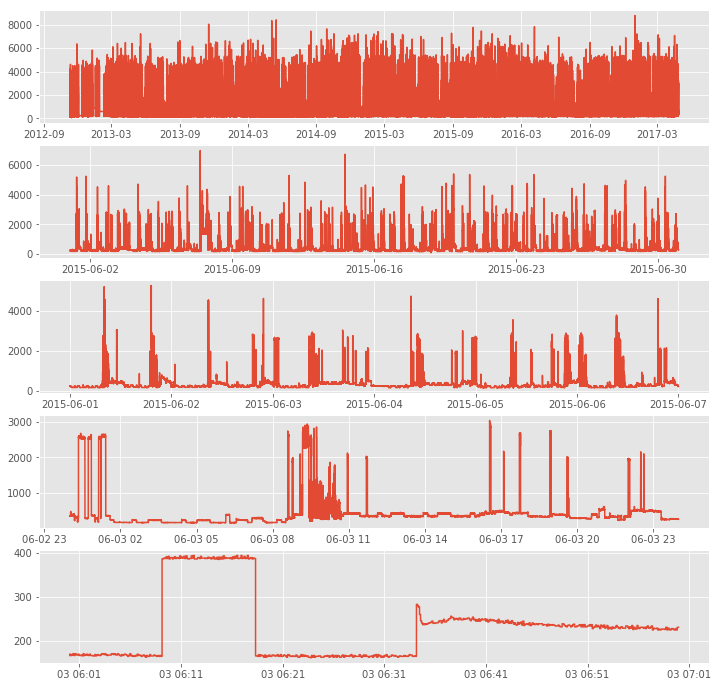

In [12]:
# setup plot
fig, axarr = plt.subplots(5,1)
fig.set_size_inches(12,12)

# loop through the list of dataframes above
for ii, df_loc in enumerate(df_all):
    axarr[ii].step(df_loc.index, df_loc.power_VA)

# save the figure
plt.savefig('ts_demo.png', bbox_inches='tight')

# this suppresses some junk output
pass

# Make Some Summary Statistics

We now want to generate some summary statistics. We think that the variations in apparent power consumption over a single day are most interesting and we are wondering whether we can build some sort of model to predict power consumption as a function of time. To get some idea of whether this is feasible, let us (i) aggregate the hourly power consumption for each hour in the day over the entire range of the time series, and then (ii) derive some prescriptive statistics.

Apparewnt power readings are sampled at intervals of a six seconds, which is a sampling rate we do not really need. To get the volume of data down while still keeping things useful, we downsample the data to an hourly representation. In particular, we average over all samples for given hour. We use the function `resample()`.

We may also have periods of missing data which have been read into our data frame as `NaN` (not a number). The Pandas function `dropna()` will remove these rows. We also create a custom column called `timestamp` which contains the same value as the `index`, which we need for some of the functionality later. This is an unfortunate quirk of Pandas...

In [13]:
# make some summary statistics

# 1 - resample hourly
#     this is the average apparent power reading over one hour
#     in other words, an apparent power consumption of an VAh/hour
df_hourly = df.resample('1h').mean()

# 2 - drop nan
df_hourly.dropna(inplace=True)

# 2 - we need the timestamp as a column to use the .dt accesor
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.dt.html#pandas-series-dt
df_hourly['timestamp'] = df_hourly.index

Let's look at the first few rows now.

In [14]:
df_hourly.head(5)

,power_VA,timestamp
timestamp,,
2012-11-09 23:00:00,474.804428,2012-11-09 23:00:00
2012-11-10 00:00:00,442.738050,2012-11-10 00:00:00
2012-11-10 01:00:00,608.406844,2012-11-10 01:00:00
2012-11-10 02:00:00,826.403377,2012-11-10 02:00:00
2012-11-10 03:00:00,173.122137,2012-11-10 03:00:00


To collect all time series data for a given hour, we write a convenience function. The function takes a data frame and extracts all readings of apparent power for this hour. We then compute the 10, 25, 50, 75, 90 percentile as well as the average for these readings. The function also take some optional arguments which we can use to select only data for a particular (i) day of the week, (ii) month of the year, and (iii) year.

Since we have averaged over one hour, our average apparent power reading in VA is equivalent to the apparent hourly consumption in units of VAh/hour.

In [15]:
def get_hourly_consumption_stats(df, day=None, month=None, year=None):
    
    # allocate memory
    # not acutally neccessary for our small arrays, but for large arrays, it's important
    q10 = np.zeros(24); q25 = np.zeros_like(q10); q50 = np.zeros_like(q10)
    q75 = np.zeros_like(q10); q90 = np.zeros_like(q10); avg = np.zeros_like(q10)
    
    # foreach hour
    for hh in range(24):
        
        # mask what we want
        mask = (df.timestamp.dt.hour == hh)
        if month:
            if type(month) is list:
                mask = mask & (df.timestamp.dt.month.isin(month))
            else:
                mask = mask & (df.timestamp.dt.month == month)
        if year:
            if type(year) is list:
                mask = mask & (df.timestamp.dt.year.isin(year))
            else:
                mask = mask & (df.timestamp.dt.year == year)
        if day:
            if type(day) is list:
                mask = mask & (df.timestamp.dt.dayofweek.isin(day))
            else:     
                mask = mask & (df.timestamp.dt.dayofweek == day)
            
        tmp = df[mask].copy()[['power_VA']]
        
        # some averaging may have gone bad produced NaN, drop those rows
        tmp.dropna(inplace=True)
        
        # get stats
        q10[hh] = np.percentile(tmp, 10)
        q25[hh] = np.percentile(tmp, 25)
        q50[hh] = np.percentile(tmp, 50)
        q75[hh] = np.percentile(tmp, 75)
        q90[hh] = np.percentile(tmp, 90)
        avg[hh] = np.mean(tmp)
        
    # return stats
    return { 'q10': q10, 'q25': q25, 'q50': q50, 'q75': q75, 'q90': q90, 'avg': avg }

Let's call the function to collect statistics for all hours of the data from the entire data set.

In [16]:
stats_all = get_hourly_consumption_stats(df_hourly)

And plot the result.

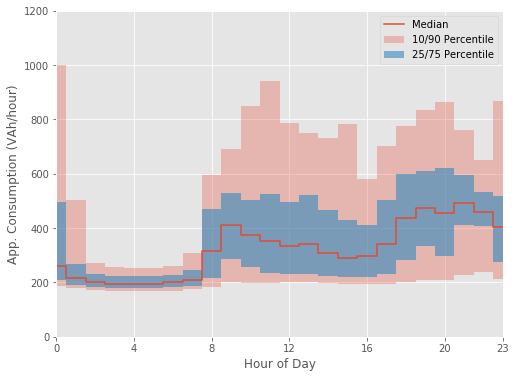

In [17]:
# Hourly Consumption Stats
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,6)
ax.fill_between(range(24), stats_all['q10'], stats_all['q90'], alpha=0.3, step='mid', label='10/90 Percentile')
ax.fill_between(range(24), stats_all['q25'], stats_all['q75'], alpha=0.6, step='mid', label='25/75 Percentile')
ax.step(range(24), stats_all['q50'], where='mid', label='Median')
ax.set_ylim([0,1200])
ax.set_xlim([0,23])
ax.set_xticks([0,4,8,12,16,20,23])
ax.legend(loc='best')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('App. Consumption (VAh/hour)')
pass

The figure shows the median (red line), 25/75 percentile range (blue shading), and 10/90 percentile range (red shading) for each hour of the day. In other words, at 09:00, 50% of the measurements (for all days from 2012 to 2017) had apparent power readings exceeding 400 VAh/h, while 90% of measurements at 08:00 had power consumption below 600 VAh/hour.

While the plot isn't super-pretty (we'll get to that later), it already tells us two important things.

1. At night-time, power consumption is very similat over the entire measurement period.
2. At day-time, power consumption can very widly.

The second observation is bad news. It means that if we want to build a forecasting mechanism, a naive implementation will likely only recover the mean (or median) value of the observations. However, such a prediction would be off by a factor of two or three from the actual consumption.

At this point, it may be time for a little feature engineering. What if there seasonal patterns to the power consumption? Let us try but computing the statistics for hourly consumption only for a given year (2016), a given month (June), or summer week-ends in a single year (Saturdays and Sundays in June, July, August 2016).

In [18]:
stats_y2016 = get_hourly_consumption_stats(df_hourly, year=2016)
stats_m6    = get_hourly_consumption_stats(df_hourly, month=6)
stats_s2016 = get_hourly_consumption_stats(df_hourly, day=[5,6], month=[5,6], year=2016)

Let's now plot the results. Observe that the figure is way prettier than above, but that this requires a bit of effort and understanding of available functions and arguments. Nevertheless, it usually pays off.

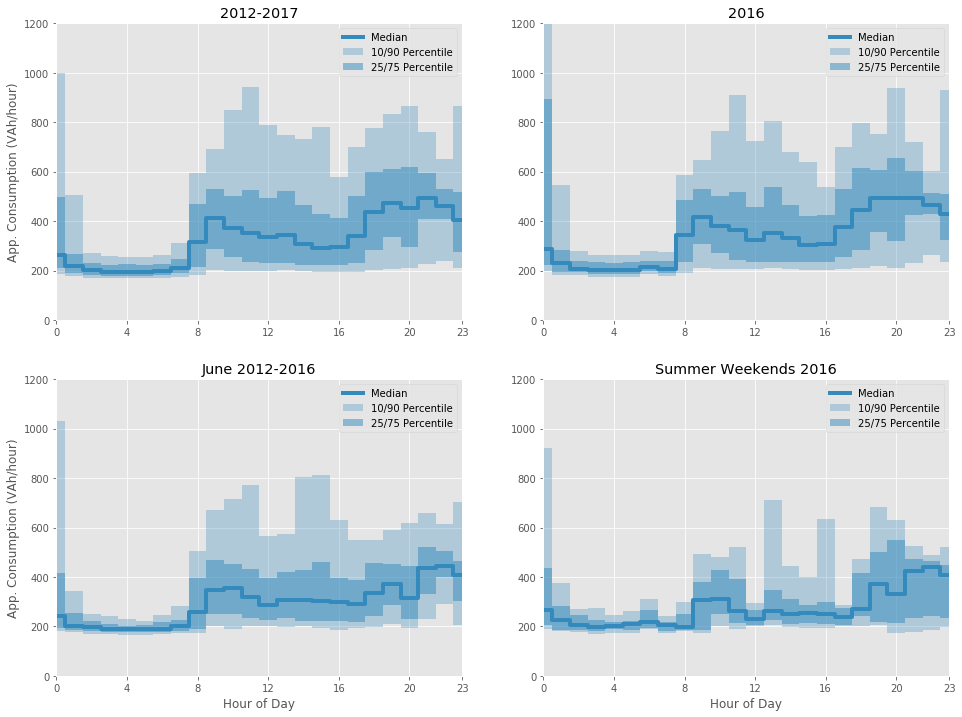

In [19]:
# set the titles
titles = [ '2012-2017', '2016', 'June 2012-2016', 'Summer Weekends 2016' ]

# setup figure
fig, axarr = plt.subplots(2,2)
fig.set_size_inches(16,12)

# plotplotplot
for iax, stats in enumerate([ stats_all, stats_y2016, stats_m6, stats_s2016]):
    axarr.flatten()[iax].fill_between(range(24), stats['q10'], stats['q90'], \
                                      facecolor='#348ABD', alpha=0.3, step='mid', \
                                      label='10/90 Percentile')
    axarr.flatten()[iax].fill_between(range(24), stats['q25'], stats['q75'],\
                                      facecolor='#348ABD', alpha=0.5, step='mid', \
                                      label='25/75 Percentile')
    axarr.flatten()[iax].step(range(24), stats['q50'], \
                              linewidth=4, color='#348ABD', where='mid', \
                              label='Median')

# fix axis limits, ticks, legend, and titles
for iax, ax in enumerate(axarr.flatten()):
    ax.set_ylim([0,1200])
    ax.set_xlim([0,23])
    ax.set_xticks([0,4,8,12,16,20,23])
    ax.legend(loc='best')
    ax.set_title(titles[iax])
    
# fix axes labels
axarr[1,0].set_xlabel('Hour of Day')
axarr[1,1].set_xlabel('Hour of Day')
axarr[0,0].set_ylabel('App. Consumption (VAh/hour)')
axarr[1,0].set_ylabel('App. Consumption (VAh/hour)')

# suppress stray messages
pass

In [20]:
# try our hand at forecasting
# (play with features)
# (which are interesting)
# (different algos?)
# (trees/svm/feedforward-nets)
# (explain lstm/rnn/cnn)

# explain difference between parametric/non-parametric???

# what about arma(x) stuff?
# is not as easy to use (requires you to think about data to adresses seasonal trends, etc)
# but trying to apply it will give you much insight into the data!
# this insight will inform you as to how well you can trust other (non-parametric) models!

In [21]:
# do cross-validation, etc

In [22]:
# style our graphics?
# cf. tufte books (minimize information-to-ink ratio)

# Let's Do Some Learning

In the Python ecosystem, the module `sklearn` provides a wide-range of classical machine learning algorithms that are ready-to-use. The same module also provides convenience functions for encoding data (for example, to convert text labels to integers or do one-hot encodings), ensembles, cross-validation, and hyperparameter tuning, we use none of this functionality. Instead, we focus on a straightforward application of decision tree regression.

We start out by instantiating the regressor with a suitable configuration. Note that nothing happens here.

In [23]:
r = sklearn.tree.DecisionTreeRegressor(max_depth=16)

For convenience, we now create a new data frame which we use to organize our features and regression target.

In [24]:
df_learning = pd.DataFrame(data = { 'timestamp': df_hourly['timestamp'], \
                                    'hour_of_day': df_hourly['timestamp'].dt.hour, \
                                    'day_of_week': df_hourly['timestamp'].dt.dayofweek, \
                                    'month_of_year': df_hourly['timestamp'].dt.month, \
                                    'power_actual_VA': df_hourly['power_VA'] })
# df_learning.reset_index(inplace=True)
df_learning.dropna(inplace=True)
df_learning[['month_of_year', 'day_of_week', 'hour_of_day', 'power_actual_VA']].head(5)

,month_of_year,day_of_week,hour_of_day,power_actual_VA
timestamp,,,,
2012-11-09 23:00:00,11,4,23,474.804428
2012-11-10 00:00:00,11,5,0,442.738050
2012-11-10 01:00:00,11,5,1,608.406844
2012-11-10 02:00:00,11,5,2,826.403377
2012-11-10 03:00:00,11,5,3,173.122137


The above shows the first five rows of data which we will train the decision tree regression on. The timestamp on the left is the index (as before), followed by `month_of_year`, `day_of_week`, and `hour_of_day` as features. The target variable is `power_actual_VA`.

We now extract the features and target variables as a matrix of the appropriate ordering.

In [25]:
x_train = np.asarray(df_learning[['month_of_year', 'day_of_week', 'hour_of_day']])
y_train = np.asarray(df_learning[['power_actual_VA']])

The following trains the decision tree on the our training set.

In [26]:
r.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=16, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

The following runs the prediction and writes the result back into our data frame which we use to organize our little experiment. We also calculate the percent different between the prediction and the actual value.

Note that we ask for a prediction on some of the same features as we have trained on. Clearly, this is a silly thing to do. Don't do this in a real experiment.

In [27]:
df_learning['power_predicted_VA'] = r.predict(x_train)

In [28]:
df_learning['power_difference_pct'] = ( (df_learning['power_actual_VA'] - df_learning['power_predicted_VA']) / \
                                         df_learning['power_predicted_VA']) * 100.0

In [29]:
df_learning[['power_actual_VA', 'power_predicted_VA', 'power_difference_pct']].head(5)

,power_actual_VA,power_predicted_VA,power_difference_pct
timestamp,,,
2012-11-09 23:00:00,474.804428,498.931800,-4.835806
2012-11-10 00:00:00,442.738050,504.039361,-12.162009
2012-11-10 01:00:00,608.406844,292.700785,107.859656
2012-11-10 02:00:00,826.403377,237.116234,248.522479
2012-11-10 03:00:00,173.122137,204.412198,-15.307335


We see that...

In [30]:
df_learning[['power_difference_pct']].describe().T

,count,mean,std,min,25%,50%,75%,max
power_difference_pct,37839.0,-3.845745e-16,52.007475,-77.981465,-30.627567,-9.865061,13.061578,577.870312


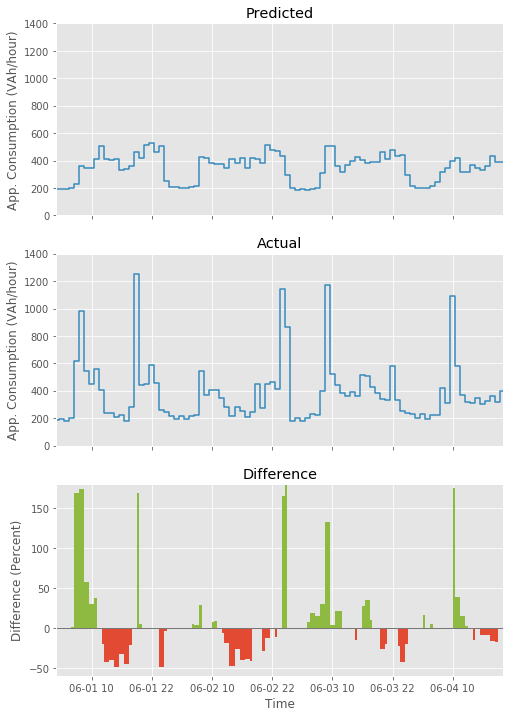

In [31]:
# plot a few days
mask = (df_learning.index >= '2015-06-01 03:00:00') & (df_learning.index < '2015-06-04 21:00:00')

# setup figure
fig, axarr = plt.subplots(3,1,sharex=True)
fig.set_size_inches(8,12)

# plotplotplot
axarr[0].step(df_learning[mask].timestamp, df_learning[mask].power_predicted_VA, color='#348ABD', where='mid')
axarr[1].step(df_learning[mask].timestamp, df_learning[mask].power_actual_VA, color='#348ABD', where='mid')

axarr[2].fill_between(df_learning[mask].index, \
                      0.0, df_learning[mask].power_difference_pct, \
                      where=df_learning[mask].power_difference_pct >= 0.0, step='mid', facecolor='#8EBA42')
axarr[2].fill_between(df_learning[mask].index, \
                      0.0, df_learning[mask].power_difference_pct, \
                      where=df_learning[mask].power_difference_pct <= 0.0, step='mid', facecolor='#E24A33')
axarr[2].plot(df_learning[mask].index, np.zeros(np.sum(mask)), color='#777777', linewidth=1.0)

# style plots
axarr[0].set_ylim([0,1400])
axarr[1].set_ylim([0,1400])
axarr[2].set_ylim([-60,180])

axarr[0].set_title('Predicted')
axarr[1].set_title('Actual')
axarr[2].set_title('Difference')

axarr[0].set_xlim([np.min(df_learning[mask].index), np.max(df_learning[mask].index)])

axarr[0].set_ylabel('App. Consumption (VAh/hour)')
axarr[1].set_ylabel('App. Consumption (VAh/hour)')
axarr[2].set_ylabel('Difference (Percent)')
axarr[2].set_xlabel('Time')

# for tick in axarr[2].get_xticklabels():
#     tick.set_rotation(45)

pass

This is a seemingly disasterous result. While the predictive model appears to -- in general -- to reproduce the daily patterns, the amplitudes for the time-range shown here are wrong by factors of two two three.

In fact, the predicted values for a given time are actually in line width the median hourly consumption (shown earlier). In other words, the predictive model is successfully learning average hourly consumption, but fails to work in hours characterised by large spreads.

Improve...???

In [32]:
# this is a terrible result...
# we could try an SVM, maybe some ensemble methods, do cross-validation, and do some voting
# these will likekly all give bad results
# the only way to get a better result here is to use an algorithm that considers neighbouring features
# this we can do with a CNN, RNN/LSTM, or even simple ARMA(X) models

heisann

- X
- Y

hello

1. A
2. B
